In [1]:
import jax
import jax.numpy as jnp
from jax import jit
import jax.random as jr
import matplotlib.pyplot as plt
import time
# %matplotlib notebook
# %matplotlib auto

# GP related libraries
import optax as ox
import gpjax as jgp
import jaxkern as jk
from jaxutils import Dataset

jax.config.update("jax_enable_x64", True)
key = jr.PRNGKey(123)

/home/hardik/Desktop/Research/FORESEE/venv311/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [2]:
f = lambda x: x[1]*jnp.sin(x[0]/10)+jnp.cos(x[3])**3

n = 50
key, subkey = jr.split(key)
x_train = jr.uniform(subkey, shape = (n,3), minval = -10.0, maxval = 10.0)
y_train = f(x_train[0,:]).reshape(-1,1)
for i in range(1,n):
    y_train = jnp.append(y_train,f(x_train[i,:]).reshape(-1,1),axis=0)
    
# key, subkey = jr.split(key)
TEST_N = 100
x_test = jr.uniform(subkey, shape=(TEST_N,3), minval = -10.0, maxval = 10.0  )
y_test = f(x_test[0,:]).reshape(-1,1)
for i in range(1,TEST_N):
    y_test = jnp.append(y_test,f(x_test[i,:]).reshape(-1,1), axis=0)


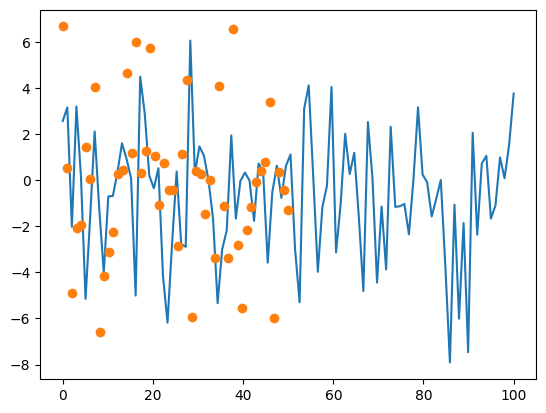

In [3]:
fig, ax = plt.subplots()#(figsize=(10,5))
plt.plot(jnp.linspace(0,TEST_N,TEST_N), y_test, label='latent functions')
plt.plot(jnp.linspace(0,n,n), y_train, "o", label='Observations')
# plt.show()

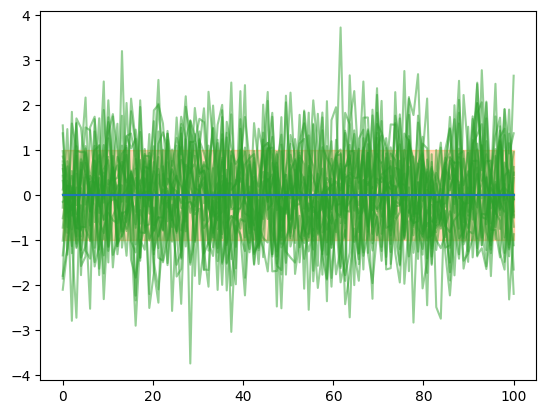

In [4]:
kernel = jk.RBF()
prior = jgp.Prior(kernel = kernel)
parameter_state = jgp.initialise(prior, key)
prior_dist = prior(parameter_state.params)(x_test)

prior_mean = prior_dist.mean()
prior_std = prior_dist.stddev()
samples = prior_dist.sample(seed=key, sample_shape=(20,)).T
fig, ax = plt.subplots()
plt.plot(jnp.linspace(0,TEST_N,TEST_N), samples, color="tab:green", alpha=0.5)
plt.plot(jnp.linspace(0,TEST_N,TEST_N), prior_mean, color="tab:blue")
plt.fill_between(
    jnp.linspace(0,TEST_N,TEST_N).flatten(),
    prior_mean - prior_std,
    prior_mean + prior_std,
    color="tab:orange",
    alpha=0.3,
)
# plt.show()

In [5]:
likelihood = jgp.Gaussian( num_datapoints=n )
posterior = prior * likelihood
parameter_state = jgp.initialise(
    posterior, key, kernel={"lengthscale": jnp.array([0.5])}
)
print(type(parameter_state))

<class 'gpjax.parameters.ParameterState'>


In [6]:
params, trainable, bijectors = parameter_state.unpack()
print(params)

{'kernel': {'lengthscale': Array([0.5], dtype=float64), 'variance': Array([1.], dtype=float64)}, 'mean_function': {}, 'likelihood': {'obs_noise': Array([1.], dtype=float64)}}


In [7]:
D = Dataset(X=x_train, y=y_train)
# marginak likelihood
negative_mll = jit(posterior.marginal_log_likelihood(D, negative=True))
negative_mll(params)

Array(191.17352329, dtype=float64)

In [8]:
optimiser = ox.adam(learning_rate=0.01)

inference_state = jgp.fit(
    objective=negative_mll,
    parameter_state=parameter_state,
    optax_optim=optimiser,
    num_iters=500,
)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 2218.48it/s, Objective=105.15]


In [9]:
learned_params, training_history = inference_state.unpack()
print(learned_params)
learned_params['likelihood']['obs_noise']

{'kernel': {'lengthscale': Array([4.92079206], dtype=float64), 'variance': Array([3.14176471], dtype=float64)}, 'likelihood': {'obs_noise': Array([1.56819506], dtype=float64)}, 'mean_function': {}}


Array([1.56819506], dtype=float64)

In [19]:
t0 = time.time()
latent_dist = posterior(learned_params, D)(x_test)
print(f"time: {time.time()-t0}")
predictive_dist = likelihood(learned_params, latent_dist)

predictive_mean = predictive_dist.mean()
predictive_std = predictive_dist.stddev()
# predictive_mean

latent_dist = posterior(learned_params, D)
t0 = time.time()
latent_dist(x_test)
print(f"time: {time.time()-t0}")
# likelihood(learned_params, latent_dist(x_test)).stddev()
latent_dist(x_test).variance()

time: 0.021863222122192383
time: 0.015812158584594727


Array([1.46815128, 1.35748547, 1.30640551, 1.11106286, 0.60947157,
       1.19808868, 1.35124244, 0.57657105, 1.54328781, 2.00069415,
       0.90713013, 0.92005198, 1.19709618, 1.39462529, 1.20690904,
       0.99230603, 1.63847434, 0.84951303, 1.40657153, 1.63218478,
       0.79310233, 0.42092369, 1.36673431, 1.25862891, 0.73446061,
       0.79263847, 0.91823186, 1.22789358, 1.43408235, 1.00311901,
       1.34274863, 1.9957255 , 0.7145701 , 1.08050426, 1.26251446,
       0.75442595, 1.29733243, 1.70903839, 0.62055185, 1.09484089,
       1.1921532 , 0.61250942, 0.65436198, 0.67227136, 1.38911217,
       1.10328811, 1.04518451, 1.90916716, 1.24615338, 1.21519374,
       0.7114435 , 0.86843433, 1.69023464, 1.27159215, 1.43682542,
       0.65764166, 1.56242237, 1.46037736, 0.37482021, 1.2153335 ,
       0.66783089, 1.18695364, 1.42659194, 1.46473935, 1.35360489,
       2.77295952, 1.29962437, 0.70550736, 2.08815601, 1.75723948,
       1.00071518, 2.1733221 , 1.55244089, 1.26674469, 1.27991

In [11]:
jnp.sqrt(1.468+1.568)

Array(1.74241212, dtype=float64, weak_type=True)

In [12]:
1.70-1.35

0.34999999999999987

In [13]:
latent_dist = posterior(learned_params, D)
def pred_mean_from_latent( learned_params, x_test ):
    predictive_dist = likelihood(learned_params, latent_dist(x_test))
    return predictive_dist.stddev()
pred_mean_from_latent_jit = jit(pred_mean_from_latent)
pred_mean_from_latent_jit( learned_params, x_test )

Array([1.7425115 , 1.71046208, 1.6954647 , 1.63684389, 1.47569191,
       1.66321488, 1.70863615, 1.464502  , 1.76393959, 1.88915039,
       1.57331662, 1.57741784, 1.66291648, 1.7212845 , 1.66586437,
       1.60015658, 1.79071757, 1.55489809, 1.72475117, 1.78896055,
       1.53665135, 1.41036121, 1.71316355, 1.68131614, 1.51745038,
       1.53650042, 1.5768408 , 1.6721509 , 1.73270811, 1.60353175,
       1.70614879, 1.88783489, 1.51088224, 1.62748251, 1.68247125,
       1.52401476, 1.6927869 , 1.81031308, 1.47944142, 1.63188111,
       1.66142958, 1.47672085, 1.49082428, 1.49681877, 1.7196823 ,
       1.63446724, 1.61659505, 1.86476868, 1.67760199, 1.66834912,
       1.5098472 , 1.56097066, 1.8051121 , 1.68516682, 1.73349949,
       1.49192383, 1.76935509, 1.74027941, 1.39392082, 1.66839101,
       1.49533473, 1.65986406, 1.73054529, 1.7415322 , 1.70932734,
       2.08354375, 1.69346374, 1.50788011, 1.91215875, 1.8235774 ,
       1.60278203, 1.93430017, 1.76653218, 1.68372793, 1.68763

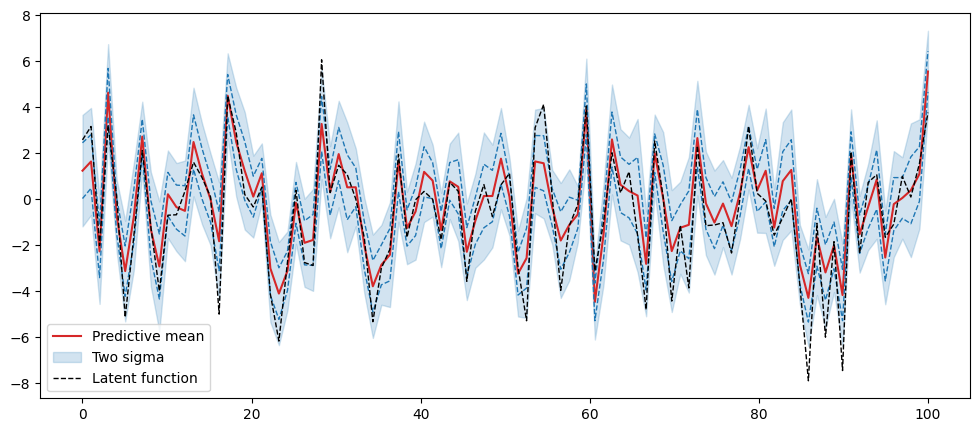

In [14]:
fig, ax = plt.subplots(figsize=(12, 5))
# ax.plot(jnp.linspace(0,n,n), y_train, "o", label="Observations", color="tab:red")
ax.plot(jnp.linspace(0,TEST_N,TEST_N), predictive_mean, label="Predictive mean", color="tab:red")
ax.fill_between(
    jnp.linspace(0,TEST_N,TEST_N).squeeze(),
    predictive_mean - 2 * predictive_std,
    predictive_mean + 2 * predictive_std,
    alpha=0.2,
    color="tab:blue",
    label="Two sigma",
)
ax.plot(
    jnp.linspace(0,TEST_N,TEST_N),
    predictive_mean - predictive_std,
    color="tab:blue",
    linestyle="--",
    linewidth=1,
)
ax.plot(
    jnp.linspace(0,TEST_N,TEST_N),
    predictive_mean + predictive_std,
    color="tab:blue",
    linestyle="--",
    linewidth=1,
)

ax.plot(
    jnp.linspace(0,TEST_N,TEST_N), y_test, label="Latent function", color="black", linestyle="--", linewidth=1
)

ax.legend()

In [15]:
latent_dist = posterior(learned_params, D)(3*x_test)
predictive_dist = likelihood(learned_params, latent_dist)

predictive_mean = predictive_dist.mean()
predictive_std = predictive_dist.stddev()
predictive_mean

Array([ 3.98473012e-03,  4.22271115e-04, -1.64758978e-01,  2.79686473e-02,
       -8.80849043e-03, -6.03681850e-03, -7.92337593e-01,  2.72202672e-02,
       -2.49340852e+00, -6.31418605e-06,  2.41284556e-03, -2.54288488e-04,
       -1.50856285e-03,  3.74491857e-04,  9.02542231e-02, -6.03882830e-02,
       -1.07542008e-07,  4.61033554e-04,  4.25518446e-03,  1.22491673e-04,
       -1.54067878e-02, -1.90558928e-02, -5.05605747e-05, -1.89318550e-07,
       -2.00305112e-02, -1.30447035e-01, -5.49915469e-05, -1.64826135e-06,
        6.58163053e-07,  1.69975784e+00,  7.89345630e-03,  3.81455516e-02,
        1.19794407e-01, -1.87581338e-01, -1.09178189e-06, -5.35330801e-01,
       -4.19718881e-02,  9.65334383e-05, -7.83275112e-02, -3.88236697e-03,
        3.78679156e-04,  6.52350190e-01, -2.38767765e+00,  8.30983992e-01,
        4.16290625e-03, -2.10922892e-03, -5.08022942e-02,  5.47514129e-06,
       -2.73250604e-05,  1.47725763e+00, -9.73293628e-04, -1.55338933e-02,
       -8.49622518e-08,  

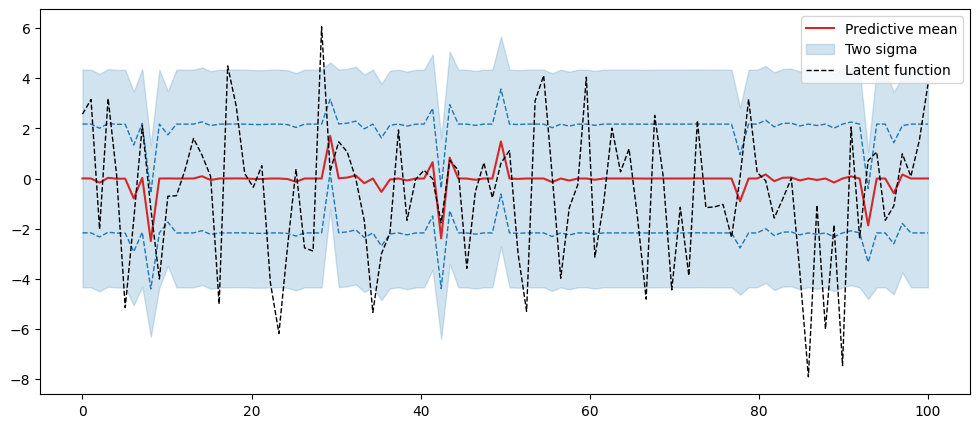

In [16]:
fig, ax = plt.subplots(figsize=(12, 5))
# ax.plot(jnp.linspace(0,n,n), y_train, "o", label="Observations", color="tab:red")
ax.plot(jnp.linspace(0,TEST_N,TEST_N), predictive_mean, label="Predictive mean", color="tab:red")
ax.fill_between(
    jnp.linspace(0,TEST_N,TEST_N).squeeze(),
    predictive_mean - 2 * predictive_std,
    predictive_mean + 2 * predictive_std,
    alpha=0.2,
    color="tab:blue",
    label="Two sigma",
)
ax.plot(
    jnp.linspace(0,TEST_N,TEST_N),
    predictive_mean - predictive_std,
    color="tab:blue",
    linestyle="--",
    linewidth=1,
)
ax.plot(
    jnp.linspace(0,TEST_N,TEST_N),
    predictive_mean + predictive_std,
    color="tab:blue",
    linestyle="--",
    linewidth=1,
)

ax.plot(
    jnp.linspace(0,TEST_N,TEST_N), y_test, label="Latent function", color="black", linestyle="--", linewidth=1
)

ax.legend()

In [16]:
def pred_mean(posterior, likelihood, learned_params, D, x_test):
    f_latent_dist = posterior(learned_params, D)(x_test)
    f_predictive_dist = likelihood(learned_params, f_latent_dist)
    f_predictive_mean = f_predictive_dist.mean()
    return f_predictive_mean
pred_mean_jit = jit(pred_mean)

In [ ]:
pred_mean(posterior, likelihood, learned_params, D, x_test)
pred_mean_jit(posterior, likelihood, learned_params, D, x_test)

In [16]:
pred_mean_lambda = lambda x : pred_mean(posterior, likelihood, learned_params, D, x)

In [17]:
%timeit pred_mean_lambda(x_test)

31.8 ms ± 2.58 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [18]:
pred_mean_lambda_jit = jit(pred_mean_lambda)

In [19]:
%timeit pred_mean_lambda_jit(x_test)

258 µs ± 32.5 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [20]:
pred_mean_lambda_jit(x_test*3)

Array([ 3.98473012e-03,  4.22271115e-04, -1.64758978e-01,  2.79686473e-02,
       -8.80849043e-03, -6.03681850e-03, -7.92337593e-01,  2.72202672e-02,
       -2.49340852e+00, -6.31418605e-06,  2.41284556e-03, -2.54288488e-04,
       -1.50856285e-03,  3.74491857e-04,  9.02542231e-02, -6.03882830e-02,
       -1.07542008e-07,  4.61033554e-04,  4.25518446e-03,  1.22491673e-04,
       -1.54067878e-02, -1.90558928e-02, -5.05605747e-05, -1.89318550e-07,
       -2.00305112e-02, -1.30447035e-01, -5.49915469e-05, -1.64826135e-06,
        6.58163053e-07,  1.69975784e+00,  7.89345630e-03,  3.81455516e-02,
        1.19794407e-01, -1.87581338e-01, -1.09178189e-06, -5.35330801e-01,
       -4.19718881e-02,  9.65334383e-05, -7.83275112e-02, -3.88236697e-03,
        3.78679156e-04,  6.52350190e-01, -2.38767765e+00,  8.30983992e-01,
        4.16290625e-03, -2.10922892e-03, -5.08022942e-02,  5.47514129e-06,
       -2.73250604e-05,  1.47725763e+00, -9.73293628e-04, -1.55338933e-02,
       -8.49622518e-08,  

In [21]:
def predict_gp_params(gp_params, train_x, train_y, test_x):
    kernel = jk.RBF()
    prior = jgp.Prior(kernel = kernel)
    likelihood = jgp.Gaussian( num_datapoints=train_x.shape[0] )
    posterior = prior * likelihood
    D = Dataset(X=train_x, y=train_y)
    latent_dist = posterior(gp_params, D)(test_x)
    predictive_dist = likelihood(gp_params, latent_dist)
    predictive_mean = predictive_dist.mean()
    return predictive_mean
    

In [31]:
%timeit predict_gp_params(learned_params, x_train, y_train, x_test*3)

29.2 ms ± 1.28 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [32]:
predict_gp_params_jit = jit(predict_gp_params)

In [34]:
%timeit predict_gp_params_jit(learned_params, x_train, y_train, 1*x_test[0,:].reshape(1,-1))

446 µs ± 7.71 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [25]:
 x_test[0,:].shape

(3,)

In [45]:
def func_a(a, b):
    a = func_b(a)
    return a + b

In [46]:
def func_b(b):
    return b**2

In [49]:
func_a_jit = jit(func_a)

In [50]:
func_a_jit(1,3)

Array(4, dtype=int64, weak_type=True)

In [23]:
a = jnp.array([[1,2], [3,4]])

In [24]:
b = jnp.array([1,2])

In [19]:
(a.T/b).T

Array([[1. , 2. ],
       [1.5, 2. ]], dtype=float64)

In [20]:
c = np.array()

Array([[1, 2],
       [3, 4]], dtype=int64)

In [21]:
a[:,1]

Array([2, 4], dtype=int64)

In [21]:
angles = jnp.array([ 0, jnp.pi ])
jnp.arctan2( jnp.sin(angles), jnp.cos(angles) )

Array([0.        , 3.14159265], dtype=float64)

In [27]:
b = jnp.array([[5,6]])
c = jnp.array([[10,11]])

In [31]:
jnp.concatenate( (b,c), axis=1 )

Array([[ 5,  6, 10, 11]], dtype=int64)

In [55]:
# @jit
def func_c(a):
    return jnp.linalg.inv(jnp.diag(a))
func_c_jit = jit(func_c)

In [53]:
%timeit func_c(jnp.array([1.0, 2.0]))

86.8 µs ± 915 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [57]:
%timeit func_c_jit(jnp.array([1.0, 2.0]))

81 µs ± 639 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [59]:
func_c_jit(jnp.array([1.0, 2.0, 3.0]))

Array([[1.        , 0.        , 0.        ],
       [0.        , 0.5       , 0.        ],
       [0.        , 0.        , 0.33333333]], dtype=float64)